Example of how one can simulate a self-calibration routine with `rubin_sim`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_sim.selfcal import generate_catalog, OffsetSys, OffsetSNR, LsqrSolver
import sqlite3
from rubin_sim.data import get_baseline
import os
from rubin_sim.utils import healbin
import time

In [2]:
# load Rubin visit history from the baseline cadence simulation. Let's do year 1, in the r filter
filter_name = "r"
survey = get_baseline()
con = sqlite3.connect(survey)
# read with pandas
visits_df = pd.read_sql("select observationId, fieldra as ra,fielddec as "
                        "dec,fiveSigmaDepth,rotSkyPos "
                        "from observations where filter='%s' and night < 365;" % filter_name, con)
con.close()

# Dump the dataframe into a simple numpy array. The to_numpy() method doesn't handle mixed dtypes well
names = ['observationId', 'ra', 'dec', 'fiveSigmaDepth', 'rotSkyPos']
types = [int, float, float, float, float]
visits = np.empty(visits_df.shape[0], dtype=list(zip(names, types)))
for key in names:
    visits[key] = visits_df[key].values

In [3]:
visits

array([(     3, 3.56288005e+02, -51.16480983, 23.12832647, 129.37513039),
       (     4, 1.58758843e-01, -53.13986356, 23.07588242, 130.10835349),
       (     5, 4.32383678e+00, -51.85868273, 23.14702605, 134.43722108),
       ...,
       (216117, 1.27022962e+02,  -4.90891688, 22.45861447, 150.93637319),
       (216118, 1.30532609e+02,  -9.18143273, 22.44788039, 146.93161495),
       (216119, 1.33615066e+02,  -8.4359143 , 22.33432064, 146.69127585)],
      dtype=[('observationId', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('fiveSigmaDepth', '<f8'), ('rotSkyPos', '<f8')])

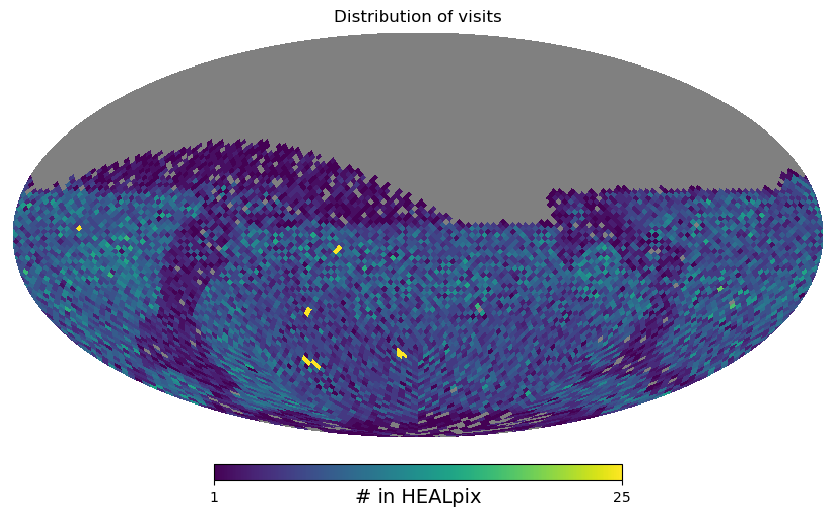

In [4]:
visit_map = healbin(visits['ra'], visits['dec'], visits['ra']*0+1, nside=32, reduce_func=np.sum)
hp.mollview(visit_map, title='Distribution of visits', unit='# in HEALpix', max=25)

In [5]:
# Generate a numpy array of stars to be used in calibration.

# This is a file from days of yore that has about 1 million stars distributed fairly evenly over dec < 0.
# Should probably make a new one of these with the simulation at NOIR lab.
# Download star database if needed
if not os.path.isfile('msrgb_1e6.sqlite'):
    import subprocess
    subprocess.call('curl https://s3df.slac.stanford.edu/data/rubin/sim-data/cal_star_databases/msrgb_1e6.sqlite --output msrgb_1e6.sqlite', shell=True)
  
# Read the stars in
con = sqlite3.connect("msrgb_1e6.sqlite")
stars_df = pd.read_sql("select id,ra,decl,%smag from stars;" % filter_name, con)
con.close()
# Repackage as numpy array
names = ['id', 'ra', 'decl', '%smag' % filter_name]
types = [int, float, float, float]
stars = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
for key in names:
    stars[key] = stars_df[key].values

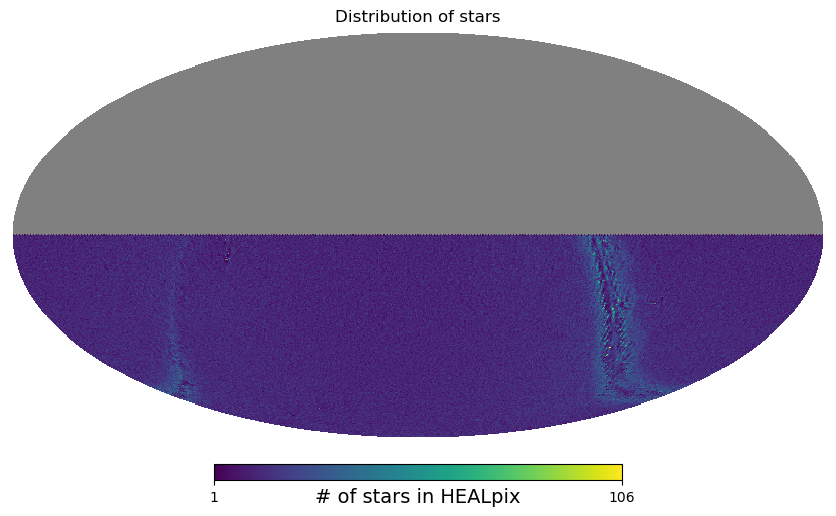

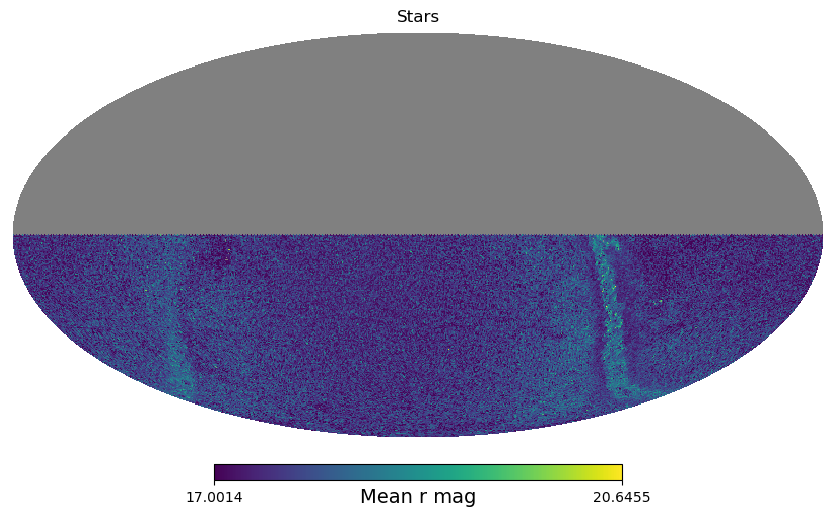

In [6]:
star_map = healbin(stars['ra'], stars['decl'], stars['ra']*0+1, nside=128, reduce_func=np.sum)
hp.mollview(star_map, title='Distribution of stars', unit='# of stars in HEALpix')

mag_map = healbin(stars['ra'], stars['decl'], stars['%smag' % filter_name], nside=128, reduce_func=np.mean)
hp.mollview(mag_map, title='Stars', unit='Mean %s mag' % filter_name)

In [7]:
# Set offsets to apply. Doing a 3% systematic to make sure there is some good noise
# The idea here is one can subclass BaseOffset and add all kinds of offsets to the 
# observed stellar magnitudes. You could have a radial gradient on the FoV, put in 
# some cloud structure, whatever you want. For now, let's just add a 0.03 mag 
# Gaussian systematic noise, and noise based on the SNR of each observation.
offsets = [OffsetSys(error_sys=0.03), OffsetSNR(lsst_filter=filter_name)]


In [8]:
# Generate a catalog of observed stars

# Note n_patches=16 means we are dividing the FoV into a 4x4 grid and solving for a patch zeropoint
# on each of those squares. In reality, we would want to set the patch size smaller (to a singe chip or even amp),
# but then we would need many more stars to be sure each patch was well sampled. Nothing stopping us from doing it,
# just need to have a deeper catalog of reference stars as input (and maybe loop over sections of the sky)
observed_stars = generate_catalog(visits, stars, offsets=offsets,
                                  lsst_filter=filter_name, n_patches=16, verbose=False)

In [9]:
observed_stars

array([( 226068,      63, 17.12848903, 0.00507415, 17.1126, 353.638, -51.2726 ),
       ( 226046,      63, 17.05562557, 0.0050649 , 17.0595, 353.525, -51.3572 ),
       (1066658,      62, 20.86197128, 0.02706583, 20.8537, 353.604, -51.5389 ),
       ...,
       ( 873709, 3457911, 17.05594536, 0.0052744 , 17.0522, 132.885,  -7.05812),
       ( 873650, 3457911, 16.98187296, 0.00524022, 17.0049, 132.388,  -7.19892),
       ( 873740, 3457911, 17.09256548, 0.005293  , 17.0812, 132.363,  -7.35595)],
      dtype=[('id', '<i8'), ('patch_id', '<i8'), ('observed_mag', '<f8'), ('mag_uncert', '<f8'), ('rmag', '<f8'), ('ra', '<f8'), ('decl', '<f8')])

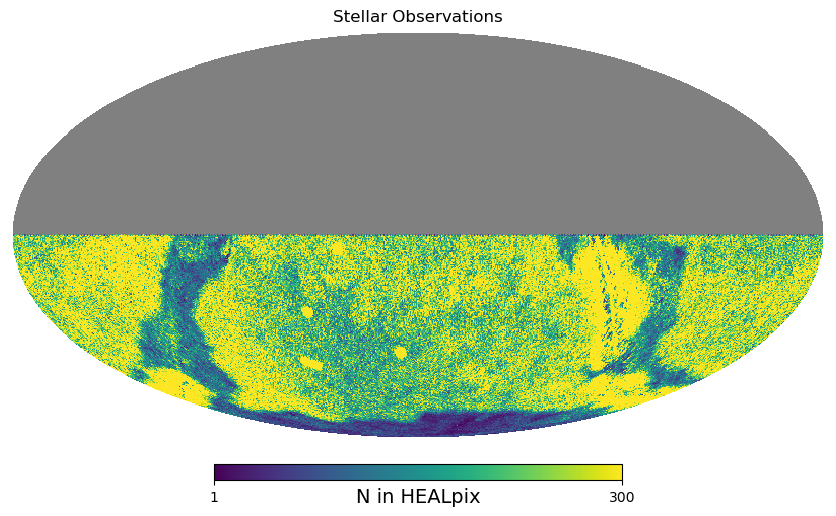

In [10]:
observed_map = healbin(observed_stars['ra'], observed_stars['decl'],
                       observed_stars['ra']*0+1, nside=128, reduce_func=np.sum)
hp.mollview(observed_map, title='Stellar Observations', unit='N in HEALpix', max=300)

In [11]:
# Construct the matrix. 
solver = LsqrSolver(observed_stars)

In [12]:
# run the solver and return the best fit values for each patch and star

# This will clean the data (eliminate patches that have only 1 star), then run LSQR from scipy
# This can take a while to grind out.
t0 = time.time()

solver.run()
fit_patches, fit_stars = solver.return_solution()
t1 = time.time()
dt = (t1-t0)/60.
print("runtime= %.1f min" % dt)

runtime= 17.6 min


Text(0.5, 1.0, 'Patches')

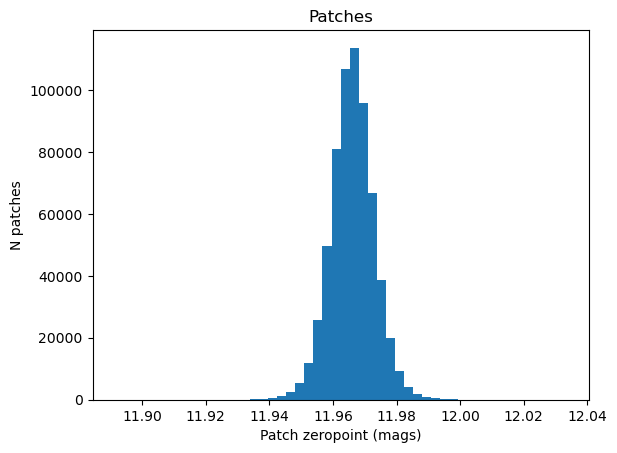

In [13]:
# how the patches converged. We have no flux standards included, so this can drift to an arbitrary zeropoint.
_temp = plt.hist(fit_patches['zp'], bins=50)
plt.xlabel('Patch zeropoint (mags)')
plt.ylabel('N patches')
plt.title('Patches')

In [14]:
# trim down truth stars to only the ones we got solutions for
stars_trimmed = stars[np.in1d(stars['id'], fit_stars['id'])]


Text(0, 0.5, 'N stars')

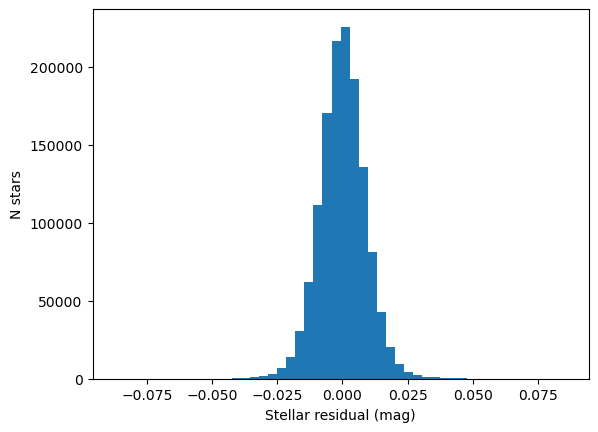

In [15]:
# Residuals after fit, removing floating zeropoint
resid = stars_trimmed['%smag' % filter_name] - fit_stars['fit_mag']
resid = resid - np.median(resid) 

_temp = plt.hist(resid, bins=50)
plt.xlabel('Stellar residual (mag)')
plt.ylabel('N stars')

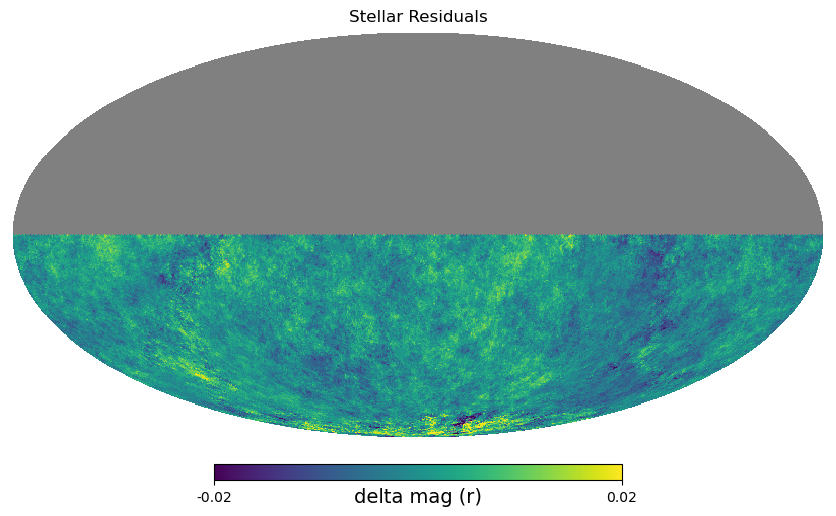

In [16]:
resid_map = healbin(stars_trimmed["ra"], stars_trimmed["decl"], resid, 128, reduce_func=np.mean)
hp.mollview(resid_map, min=-0.02, max=0.02, title='Stellar Residuals', unit='delta mag (%s)' % filter_name)